Hidden Markov Model for POS Tagging.

This program trains on a POS-tagged corpus and then tag the untagged corpus and then display the accuracy.

In [3]:
import nltk
import numpy as np
import conllu
from sklearn.metrics import accuracy_score

# Read training data
with open('en_ewt-ud-train.conllu', 'rb') as f:
    train_data_str = f.read().decode('utf-8')
train_data = conllu.parse(train_data_str)

# Read test data
with open('en_ewt-ud-test.conllu', 'rb') as f:
    test_data_str = f.read().decode('utf-8')
test_data = conllu.parse(test_data_str)

# Extract words and POS tags from training data
train_words = []
train_tags = []
for sentence in train_data:
    for token in sentence:
        train_words.append(token['form'])
        train_tags.append(token['upostag'])

#Print 5 sentences in train_data
for i, sentence in enumerate(train_data):
    if i >= 5:
        break
    sentence_words = [token['form'] for token in sentence]
    sentence_tags = [token['upostag'] for token in sentence]
    print('Sentence:', sentence_words)
    print('Tags:', sentence_tags)
    print()

Sentence: ['Al', '-', 'Zaman', ':', 'American', 'forces', 'killed', 'Shaikh', 'Abdullah', 'al', '-', 'Ani', ',', 'the', 'preacher', 'at', 'the', 'mosque', 'in', 'the', 'town', 'of', 'Qaim', ',', 'near', 'the', 'Syrian', 'border', '.']
Tags: ['PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'PROPN', 'PUNCT', 'ADP', 'DET', 'ADJ', 'NOUN', 'PUNCT']

Sentence: ['[', 'This', 'killing', 'of', 'a', 'respected', 'cleric', 'will', 'be', 'causing', 'us', 'trouble', 'for', 'years', 'to', 'come', '.', ']']
Tags: ['PUNCT', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'AUX', 'AUX', 'VERB', 'PRON', 'NOUN', 'ADP', 'NOUN', 'PART', 'VERB', 'PUNCT', 'PUNCT']

Sentence: ['DPA', ':', 'Iraqi', 'authorities', 'announced', 'that', 'they', 'had', 'busted', 'up', '3', 'terrorist', 'cells', 'operating', 'in', 'Baghdad', '.']
Tags: ['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'SCONJ', 'PRON

In [4]:
# Get unique words and tags
unique_words = list(set(train_words))
unique_tags = list(set(train_tags))

# Create word and tag dictionaries for mapping
word2idx = {word: idx for idx, word in enumerate(unique_words)}
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}

# Print unique words and tags
print("| Word | POS Tag |")
print("| --- | --- |")
for word, tag in zip(unique_words, unique_tags):
    print(f"| {word} | {tag} |")

| Word | POS Tag |
| --- | --- |
| Aerocom | NOUN |
| anti-American | X |
| listeners | PUNCT |
| tick | INTJ |
| Bart | SCONJ |
| Bowtie | PRON |
| dropped | NUM |
| thursday | SYM |
| melted | AUX |
| deeper | _ |
| terribly | PART |
| Muhammad | ADJ |
| Global's | PROPN |
| morbidity | ADP |
| made | ADV |
| Shakespearean | CCONJ |
| intrigue | DET |
| Beardies | VERB |


In [5]:
# Calculate transition and emission probabilities
N_STATES = len(unique_tags)
N_OBSERVATIONS = len(unique_words)

# Initialize transition and emission probability matrices to zeros
transition_probs = np.zeros((N_STATES, N_STATES))
emission_probs = np.zeros((N_STATES, N_OBSERVATIONS))

# Loop through the training data and calculate transition and emission probabilities
prev_tag_idx = None
for word, tag in zip(train_words, train_tags):
    # Map word and tag to their corresponding integer indices
    word_idx = word2idx[word]
    tag_idx = tag2idx[tag]

    # Update transition probability from previous tag to current tag
    if prev_tag_idx is not None:
        transition_probs[prev_tag_idx, tag_idx] += 1

    # Update emission probability of current tag for current word
    emission_probs[tag_idx, word_idx] += 1

    # Update previous tag index
    prev_tag_idx = tag_idx

# Normalize transition and emission probabilities
transition_probs /= transition_probs.sum(axis=1, keepdims=True)
emission_probs /= emission_probs.sum(axis=1, keepdims=True)


**visualize the steps for calculating the transition and emission probabilities**

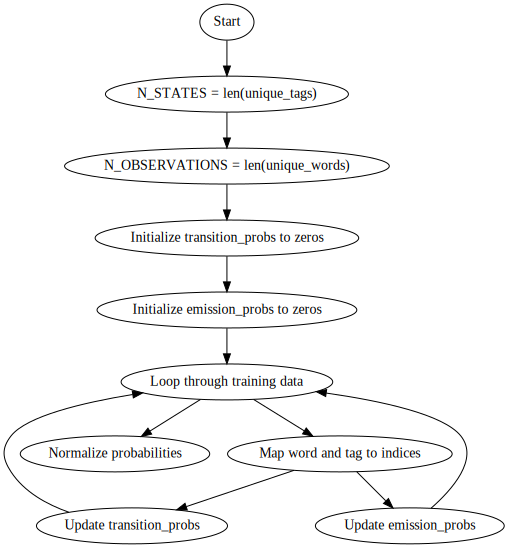

In [6]:
# Install Graphviz library
!pip install graphviz

# Import necessary libraries
from graphviz import Digraph
from IPython.display import display

# Create a new directed graph
dot = Digraph()

# Add nodes
dot.node('Start', 'Start')
dot.node('N_STATES', 'N_STATES = len(unique_tags)')
dot.node('N_OBSERVATIONS', 'N_OBSERVATIONS = len(unique_words)')
dot.node('transition_probs_init', 'Initialize transition_probs to zeros')
dot.node('emission_probs_init', 'Initialize emission_probs to zeros')
dot.node('Loop', 'Loop through training data')
dot.node('Map', 'Map word and tag to indices')
dot.node('Transition_Update', 'Update transition_probs')
dot.node('Emission_Update', 'Update emission_probs')
dot.node('Normalize', 'Normalize probabilities')

# Add edges to show the flow
dot.edge('Start', 'N_STATES')
dot.edge('N_STATES', 'N_OBSERVATIONS')
dot.edge('N_OBSERVATIONS', 'transition_probs_init')
dot.edge('transition_probs_init', 'emission_probs_init')
dot.edge('emission_probs_init', 'Loop')
dot.edge('Loop', 'Map')
dot.edge('Map', 'Transition_Update')
dot.edge('Map', 'Emission_Update')
dot.edge('Transition_Update', 'Loop')
dot.edge('Emission_Update', 'Loop')
dot.edge('Loop', 'Normalize')

# Display the graph inline
display(dot)


In [7]:

# Define a smoothing parameter
smoothing = 0.0001

# Calculate emission probabilities with smoothing
emission_probs_smoothed = (emission_probs + smoothing) / (emission_probs.sum(axis=1, keepdims=True) + smoothing * N_OBSERVATIONS)


# Define a special token for unknown words
UNK_TOKEN = '<UNK>'

# Create word and tag dictionaries for mapping, including the special token
word2idx = {word: idx for idx, word in enumerate(unique_words + [UNK_TOKEN])}
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags + [UNK_TOKEN])}

# Calculate emission probabilities with smoothing, including the special token
emission_probs_smoothed = np.zeros((N_STATES, N_OBSERVATIONS + 1))
for tag_idx in range(N_STATES):
    for word_idx in range(N_OBSERVATIONS):
        emission_probs_smoothed[tag_idx, word_idx] = (emission_probs[tag_idx, word_idx] + smoothing) / (emission_probs[tag_idx].sum() + smoothing * N_OBSERVATIONS)
    # Assign the smoothed probability for the special token
    emission_probs_smoothed[tag_idx, N_OBSERVATIONS] = smoothing / (emission_probs[tag_idx].sum() + smoothing * N_OBSERVATIONS)

# Function to get word index with handling of unknown words
def get_word_index(word):
    return word2idx.get(word, N_OBSERVATIONS)  # Return N_OBSERVATIONS for unknown words

In [8]:

# Process the test data to replace unknown words with '<UNK>'
def replace_unknown_words(sentence, word2idx, unk_token):
    return [word if word in word2idx else unk_token for word in sentence]

# Find and display sentences with unknown words
def find_sentences_with_unk(test_data, word2idx, unk_token):
    sentences_with_unk = []
    for sentence in test_data:
        sentence_words = [token['form'] for token in sentence]
        replaced_sentence = replace_unknown_words(sentence_words, word2idx, unk_token)
        if unk_token in replaced_sentence:
            sentences_with_unk.append((sentence_words, replaced_sentence))
    return sentences_with_unk

# Get sentences with unknown words
unk_sentences = find_sentences_with_unk(test_data, word2idx, UNK_TOKEN)

# Display examples
for i, (original_sentence, replaced_sentence) in enumerate(unk_sentences[:5]):
    print(f"Sentence {i+1}:")
    print("Original:", " ".join(original_sentence))
    print("Replaced:", " ".join(replaced_sentence))
    print()

Sentence 1:
Original: What if Google Morphed Into GoogleOS ?
Replaced: What if Google <UNK> Into <UNK> ?

Sentence 2:
Original: What if Google expanded on its search - engine ( and now e-mail ) wares into a full - fledged operating system ?
Replaced: What if Google expanded on its search - engine ( and now e-mail ) <UNK> into a full - <UNK> operating system ?

Sentence 3:
Original: [ via Microsoft Watch from Mary Jo Foley ]
Replaced: [ via Microsoft Watch from Mary <UNK> <UNK> ]

Sentence 4:
Original: ( And , by the way , is anybody else just a little nostalgic for the days when that was a good thing ? )
Replaced: ( And , by the way , is anybody else just a little <UNK> for the days when that was a good thing ? )

Sentence 5:
Original: This BuzzMachine post argues that Google's Google 's rush toward ubiquity might backfire -- which we've we 've all heard before , but it's it 's particularly well - put in this post .
Replaced: This <UNK> post <UNK> that <UNK> Google 's rush toward <UNK>

In [ ]:
# Implement Viterbi algorithm with handling of unknown words
def viterbi(obs, states, trans, emiss):
    T = len(obs)
    N = len(states)
    delta = np.zeros((T, N))
    delta[0] = emiss[:, get_word_index(obs[0])]
    psi = np.zeros((T, N), dtype=int)

    for t in range(1, T):
        for n in range(N):
            word_idx = get_word_index(obs[t])
            if word_idx == N_OBSERVATIONS:
                # For unknown words, use smoothed emission probabilities
                emit_prob = emission_probs_smoothed[n, word_idx]
            else:
                emit_prob = emiss[n, word_idx]

            # Calculate delta with emission probability for unknown words
            max_delta = 0
            for m in range(N):
                temp_delta = delta[t-1, m] * trans[m, n] * emit_prob
                if temp_delta > max_delta:
                    max_delta = temp_delta
                    psi[t, n] = m
            delta[t, n] = max_delta

    # Backtrack to find the best sequence
    best_seq = np.zeros(T, dtype=int)
    best_seq[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        best_seq[t] = psi[t+1, best_seq[t+1]]

    return best_seq

# Evaluate the trained model with handling of unknown words
def evaluate_hmm(test_data, word2idx, tag2idx):
    predicted_tags = []
    true_tags = []

    for sentence in test_data:
        obs = [token['form'] for token in sentence]
        true_tags.extend([tag2idx[token['upostag']] for token in sentence])

        # Predict using Viterbi algorithm with handling of unknown words
        pred_tags = viterbi(obs, unique_tags, transition_probs, emission_probs_smoothed)
        predicted_tags.extend(pred_tags)

    return predicted_tags, true_tags

# Evaluate the trained model with handling of unknown words
predicted_tags, true_tags = evaluate_hmm(test_data, word2idx, tag2idx)

# Calculate accuracy
accuracy = accuracy_score(true_tags, predicted_tags)
print("Accuracy with unknown word handling:", accuracy)

Conditional Random Field program

This below program should have the same function and do the work the same as the previous program.

In [ ]:
!pip install conllu
!pip install sklearn_crfsuite
import numpy as np
import conllu
from sklearn_crfsuite import CRF
from sklearn.metrics import classification_report


# Read training data
with open('en_ewt-ud-train.conllu', 'rb') as f:
    train_data_str = f.read().decode('utf-8')
train_data = conllu.parse(train_data_str)

# Read test data
with open('en_ewt-ud-test.conllu', 'rb') as f:
    test_data_str = f.read().decode('utf-8')
test_data = conllu.parse(test_data_str)

# Function to extract features from a sentence
def extract_features(sentence, idx):
    word = sentence[idx]['form']
    features = {
        'word': word,
        'is_first': idx == 0,
        'is_last': idx == len(sentence) - 1,
        'prev_word': '' if idx == 0 else sentence[idx - 1]['form'],
        'next_word': '' if idx == len(sentence) - 1 else sentence[idx + 1]['form'],
        'prev_tag': '' if idx == 0 else sentence[idx - 1]['upostag'],
        'next_tag': '' if idx == len(sentence) - 1 else sentence[idx + 1]['upostag']
    }
    return features

# Function to extract features for the entire dataset
def extract_dataset_features(dataset):
    X = []
    y = []
    for sentence in dataset:
        X_sentence = [extract_features(sentence, i) for i in range(len(sentence))]
        y_sentence = [token['upostag'] for token in sentence]
        X.append(X_sentence)
        y.append(y_sentence)
    return X, y

# Transform dataset to features and labels
X_train, y_train = extract_dataset_features(train_data)
X_test, y_test = extract_dataset_features(test_data)

# Initialize CRF model
crf = CRF()

# Train CRF model
crf.fit(X_train, y_train)

# Predict labels for test data
y_pred = crf.predict(X_test)

# Flatten true and predicted labels
y_true_flat = [tag for sentence_tags in y_test for tag in sentence_tags]
y_pred_flat = [tag for sentence_tags in y_pred for tag in sentence_tags]

# Print classification report
print(classification_report(y_true_flat, y_pred_flat))

# Display the dependency count for words and tags
def display_dependency_count():
    num_word_dependencies = 3  # current word, previous word, next word
    num_tag_dependencies = 2  # previous tag, next tag

    print(f"The CRF model depends on {num_word_dependencies} words and {num_tag_dependencies} tags to tag the current word.")

# Call the function to display dependency count
display_dependency_count()
